(tensor-network-contraction)=

# Contraction

One of the core tasks of any tensor network algorithm is *contracting* a network of tensors into the single tensor, be it scalar or multi-dimensional, that it implicitly represents and a key part of `quimb` is handling this process automatically. In short, anywhere you see the `optimize` kwarg, it specifies what strategy to use for *automatic* contraction, and it is worth noting that there is always some trade-off between time spent optimizing the order, and then actually executing it.

Before explaining the options, we'll first briefly explain the task and problem, setting up a simple initial TN:

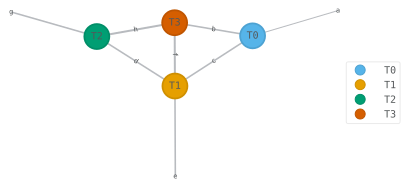

outer inds: ('a', 'e', 'g')


In [2]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn

tn = qtn.TensorNetwork((
    qtn.rand_tensor([2, 3, 3], ['a', 'b', 'c'], 'T0'),
    qtn.rand_tensor([3, 3, 3, 4], ['c', 'd', 'e', 'f'], 'T1'),
    qtn.rand_tensor([3, 3, 4], ['d', 'g', 'h'], 'T2'),
    qtn.rand_tensor([4, 3, 4], ['h', 'b', 'f'], 'T3'),
))
tn.draw(['T0', 'T1', 'T2', 'T3'], show_inds="all")
print("outer inds:", tn.outer_inds())

This network by default has 'outer' indices ('a', 'e', 'g'), and can be thought of as a *lazy* representation of the 3D tensor with those indices. The actual 3D tensor is what we get when we [`contract`](quimb.tensor.tensor_core.TensorNetwork.contract) it:

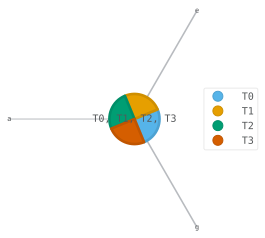

In [3]:
tn.contract().draw(['T0', 'T1', 'T2', 'T3'], figsize=(4, 4))

The mathematical definition of this operation can be written as a 'sum over products' like so:

$$
T_{\{ x_\mathrm{out} \}} = \sum_{ \{ x\} / \{ x_\mathrm{out} \} }  \prod_i T^i_{\{ x_i \}}
$$

Here $\{x\}$ is the set of all indices, $T^{[i]}_{\{x_i\}}$ is the ith tensor, indexed by set of indices incident to it $\{x_i\}$, and $\{x_\mathrm{out}\}$ is the set of indices we are not summing over, often called the **'output'** or **'outer'** indices. Expanding out this shorthand for our tensor network gives us:

$$
T_{aeg} = \sum_{c=0}^3\sum_{d=0}^3\sum_{b=0}^3\sum_{f=0}^4\sum_{h=0}^4 T^0_{abc} T^1_{cdef} T^2_{dgh} T^3_{hbf}
$$

Written in this way, you can see that each term in the sum is a product of scalars (combinations of specific entries of each tensor), but the number of terms scales exponentially in the number of indices. Naively performing the sum explicitly has essentially no space-cost, but a very badly scaling time-cost!

```{hint}
The default version of [`numpy.einsum`](numpy.einsum) (with `optimize=False`) performs the contraction in this way, it can still be practical in some cases involving small or few tensors.
```

Crucially however, we can 'move' sums into the expression, performing just that sum over only the tensors that have the relevant index:

$$
T_{aeg} = \sum_{c=0}^3\sum_{d=0}^3\sum_{b=0}^3\sum_{f=0}^4 T^0_{abc} T^1_{cdef} \left(\sum_{h=0}^4 T^2_{dgh} T^3_{hbf} \right)
\\
T_{aeg} = \sum_{c=0}^3\sum_{d=0}^3\sum_{b=0}^3\sum_{f=0}^4 T^0_{abc} T^1_{cdef} T^5_{dgbf}
$$

This partial contraction to form $T^5$ is referred to as an *intermediate*, and we can repeat this process of choosing pairs of tensors to contract until only a single tensor is left.

$$
T_{aeg} = \sum_{c=0}^3\sum_{b=0}^3 T^0_{abc} \left( \sum_{d=0}^3 \sum_{f=0}^4 T^1_{cdef} T^5_{dgbf} \right)
\\
T_{aeg} = \sum_{c=0}^3\sum_{b=0}^3 T^0_{abc} T^6_{cegb}
$$

The order, or 'path', we do this in can be described as a binary *contraction tree*. It is always optimal time-wise to perform a contraction this way (with a cost that scales exponentially in the maximum number of indices appearing in any **single pairwise contraction**), though there is now a space-cost associated with forming the intermediate tensors.

```{note}
Exact contraction of an *arbitrary* tensor network still scales exponentially, even if the order is optimized, but certain geometries, specifially tree- and fractal- like, can be reduced to polynomial cost.
```

As the number of tensors grows, the number of possible contraction trees grows very quickly, and the total cost is extraordinarily sensitive to the particular tree chosen. This tricky optimization problem is handled for `quimb` using the [`cotengra`](https://cotengra.readthedocs.io) library, which is focused specifically on finding contraction trees and performing contractions.

The `optimize` kwarg tells `cotengra` what strategy to use to find the contraction tree, and we can inspect the tree before we actually perform the contraction:

In [9]:
tree = tn.contraction_tree(optimize="greedy")
tree.print_contractions()
tree.describe()

(0) cost: 4.3e+02 widths: 5.2,5.6->6.8 type: tensordot
inputs: dg[h],[h]bf->
output: dg(bf)

(1) cost: 9.7e+02 widths: 6.8,6.8->6.3 type: tensordot
inputs: [d]gb[f],c[d]e[f]->
output: gb(ce)

(2) cost: 1.6e+02 widths: 6.3,4.2->4.2 type: tensordot+perm
inputs: g[bc]e,a[bc]->
output: (a)eg




'log10[FLOPs]=3.19 log2[SIZE]=6.75'

So there will be $\sim 10^{3.19} = 1566$ scalar operations with a largest intermediate
of size $\sim 2^{6.75} = 108$ elements (to get actual flops and memory you will need to scale by data-type etc.).


We can visualize the tree in a number of ways:

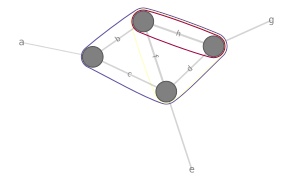

In [5]:
tree.plot_rubberband();

```{hint}
`quimb` uses arbitrary strings for indices, whilst `cotengra` uses single
unicode characters, so the labels will not always match up. You can call
[`tn.get_symbol_map()`](quimb.tensor.tensor_core.TensorNetwork.get_symbol_map)
to see the mapping.
```

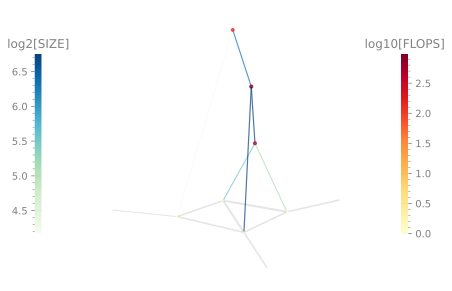

In [6]:
tree.plot_tent(order=True);

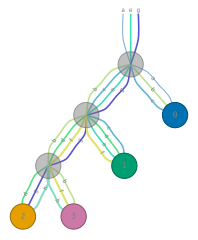

In [7]:
tree.plot_flat();

See the [`cotengra`](cotengra) documentation for more details on the contraction tree.

## Contraction Interfaces

Contraction in `quimb` is accessed through various functions and methods. The
main three being:

* [`qtn.tensor_contract`](quimb.tensor.tensor_core.tensor_contract) - this is the core function
  that takes a collection of [`Tensor`](quimb.tensor.tensor_core.Tensor) objects, finds the contraction tree, and performs the contraction. Most other contractions methods call this under the hood and pass any kwargs on to this.
* [`ta @ tb`](quimb.tensor.tensor_core.Tensor.__matmul__) - this simply contracts two tensors, assuming all shared indices should be contracted away.
* [`TensorNetwork.contract`](quimb.tensor.tensor_core.TensorNetwork.contract) - this is the main method for contracting all or part of a TN, possibly using a structured method or approximation contraction.

Then there are more specialized methods:

* [`TensorNetwork.contract_tags`](quimb.tensor.tensor_core.TensorNetwork.contract_tags): contract partial **subgraphs** within a TN based with matching `tags`.
* [`TensorNetwork.contract_between`](quimb.tensor.tensor_core.TensorNetwork.contract_between): contract a **pair** of tensors, identified by different tags.
* [`TensorNetwork.contract_ind`](quimb.tensor.tensor_core.TensorNetwork.contract_ind): contract all tensors within a TN that share a **particular index**.
* [`TensorNetwork.contract_cumulative`](quimb.tensor.tensor_core.TensorNetwork.contract_cumulative): contract tensors using a **`bubble`** order of tags.
* [`TensorNetwork.to_dense`](quimb.tensor.tensor_core.TensorNetwork.to_dense): contract **and fuse** groups of outer indices into an output array.
* [`TensorNetwork.trace`](quimb.tensor.tensor_core.TensorNetwork.trace): glue two sequences of outer indices together and the contract everything.

Plus many more methods - anywhere you see the `optimize` kwargs.
There are also various method for extracting *information* about a contraction before actually performing it:

* [`TensorNetwork.contraction_path`](quimb.tensor.tensor_core.TensorNetwork.contraction_path): the `numpy` or [`opt_einsum`](https://optimized-einsum.readthedocs.io) style `path`. This is the most compact way to store and reuse a particular ordering. See below for its definition.
* [`TensorNetwork.contraction_tree`](quimb.tensor.tensor_core.TensorNetwork.contraction_tree): the [`cotengra.ContractionTree`](cotengra.ContractionTree) object, which allows one to visualize and query all attributes of the contraction, such as FLOPs and memory requirements.
* [`TensorNetwork.contraction_info`](quimb.tensor.tensor_core.TensorNetwork.contraction_info): the [`opt_einsum.PathInfo`](opt_einsum.PathInfo) object, an alternative informational object with some of same information.
* [`TensorNetwork.contraction_width`](quimb.tensor.tensor_core.TensorNetwork.contraction_width): *log2 of the maximum size of any intermediate tensor*, useful for estimating memory requirements.
* [`TensorNetwork.contraction_cost`](quimb.tensor.tensor_core.TensorNetwork.contraction_cost): the total number of scalar multiplications required to perform the contraction, useful for estimating time requirements.

## The `optimize` kwarg:

The optimize kwarg can generally take one of the following options:

### `str` preset

- `'auto'` - a decent default for one-off contractions
- `'auto-hq'` - a decent default for repeated contractions or when higher quality is needed
- `'greedy'` - a super quick optimizer that is fine for simple networks
- `'optimal'` - exponential cost but OK for small networks
- `'random-greedy'` - pretty quick with decent results, good for large networks
- `'random-greedy-128'` - the same but with 4x more trials for higher quality

The auto methods use optimal path finding for small networks, then switch to random-greedy for hyper-optimized methods for larger networks.

### `cotengra.HyperOptimizer`

To really customize the path-finding process and investigate contaction costs you may want to supply a customized [`cotengra.HyperOptimizer`](cotengra.HyperOptimizer) instance:

In [19]:
import cotengra as ctg

# standard optimizers can only be supplied to a single contraction,
# -> if supplied more than once they simply run for longer
opt = ctg.RandomGreedyOptimizer(max_repeats=1024)

# reusable means it is like a 'preset' we can supply it to many different
# contractions -> if it sees the same network it will recall the previous tree
opt = ctg.ReusableHyperOptimizer(
    # turn on subtree reconfiguration for higher quality path
    reconf_opts={},
    # target both flops and write - usually wise for practical performance
    minimize="combo",
    # only spend time on hard contractions
    max_time="rate:1e9",
    # hash contraction up to index permutation, for maximum reuse
    hash_method="b",
    # cmaes is a good balance between speed and quality
    optlib="cmaes",
    # store contractions on disk
    directory=True,
    # turn this on to see live progress each contraction
    progbar=False,
)

### `opt_einsum` `PathOptimizer`

`quimb` also accepts [`opt_einsum.PathOptimizer`](opt_einsum.PathOptimize) instances, (though `cotengra` is the preferred method).

In [22]:
import opt_einsum as oe

opt = oe.RandomGreedy()

### Explicit contraction paths

### path, ssa_path, tree

### path caching

geometry hash

caching within cotengra


## Hyper edges and `output_inds`

most general einsum equation


## Structured Contractions

e.g. 1D chain


## Approximate boundary contraction

coarse graining contractions

hyper edges not supported


## Automatic approximate / compressed contraction

* [`contract_compressed`](quimb.tensor.tensor_core.TensorNetwork.contract_compressed)
* contract_around


## `strip_exponent` and equalize_norms